In [1]:
import scanpy as sc
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import bbknn
import scipy.stats
import numpy as np

In [2]:
import sys
sys.path.insert(0, "../lib")

In [4]:
import sc_utils

In [5]:
mpl.rcParams["figure.figsize"] = (12, 12)
pd.set_option('display.max_rows', 1000)

## Load RC1 object

In [5]:
ds = sc.read_h5ad("../data/04dataset/03obj-manual.h5ad")

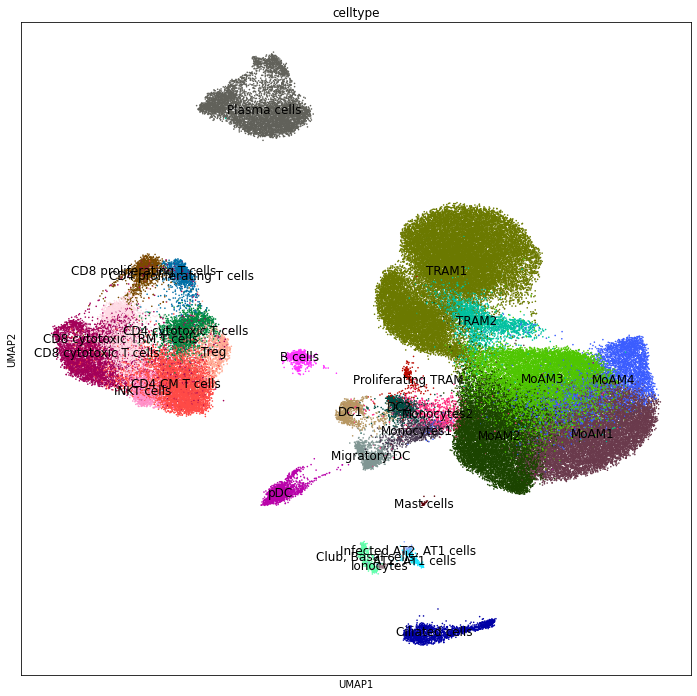

In [6]:
sc.pl.umap(
    ds, 
    color="celltype", 
    size=10, 
    legend_loc="on data",
#     legend_fontoutline=3,
    legend_fontweight="normal",
    legend_fontsize=12
)

## Load RC2 object

This object has genotypic doublets removed, but does not have celltype metadata, which we will transfer from RC1 object

In [18]:
rc2 = sc.read_h5ad("../data/04dataset/04obj.h5ad")

In [8]:
rc2.shape

(105766, 21819)

51 doublet cells from cluster 13, see 05tram-day0.ipynb

In [9]:
rc2 = rc2[rc2.obs_names.isin(ds.obs_names), :]

In [10]:
rc2.shape

(105715, 21819)

In [11]:
rc2.obs = ds.obs.loc[rc2.obs_names, :].copy()

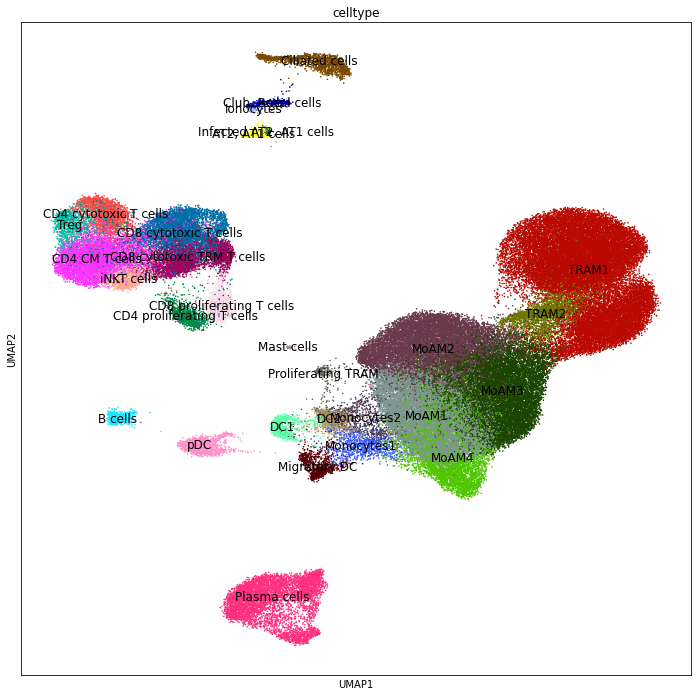

In [12]:
sc.pl.umap(
    rc2, 
    color="celltype", 
    size=10, 
    legend_loc="on data",
#     legend_fontoutline=3,
    legend_fontweight="normal",
    legend_fontsize=12
)

## Add Interferon signatures

In [13]:
ifn_response_genes = {
    "HALLMARK_INTERFERON_ALPHA_RESPONSE": "IFNA Response",
    "HALLMARK_INTERFERON_GAMMA_RESPONSE": "IFNG Response"
}

In [14]:
for k, v in ifn_response_genes.items():
    genes = pd.read_table(f"{k}.txt", skiprows=2, header=None)
    sc.tl.score_genes(rc2, genes[0], ctrl_size=genes.size, score_name=v)

## Save RC2 object with correct metadata

In [47]:
rc2.write_h5ad("../data/04dataset/04obj-manual.h5ad")

In [52]:
sc.tl.rank_genes_groups(rc2, "celltype", method="wilcoxon", n_genes=200)
markers = sc_utils.get_markers(rc2, "celltype")

In [53]:
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False]).to_csv("04markers.csv")

In [34]:
rc2.obs.to_csv("04metadata.csv")

## Subset on COVID-only

In [35]:
covid = rc2[rc2.obs["COVID-19"] == "True", :].copy()

In [7]:
covid = covid.raw.to_adata()

In [8]:
sc.pp.highly_variable_genes(covid, n_top_genes=4500, batch_key="orig.ident")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.

In [9]:
covid.var.highly_variable[covid.var_names.str.match("^SARS-CoV-2")] = False

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
covid.raw = covid

In [11]:
sc.pp.scale(covid)
sc.tl.pca(covid, svd_solver="arpack")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


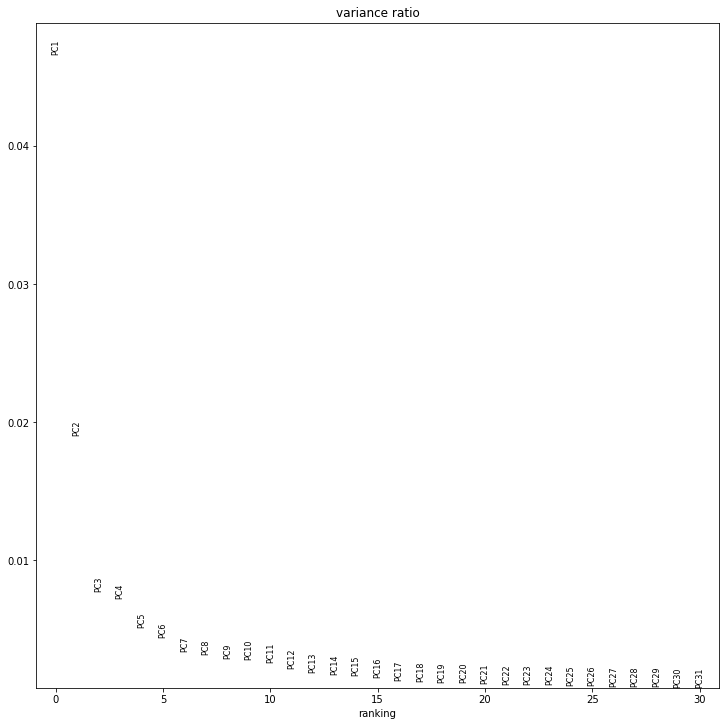

In [12]:
sc.pl.pca_variance_ratio(covid)

4500 150/25 is good

In [13]:
bbknn.bbknn(covid, neighbors_within_batch=int(150 / covid.obs.batch.unique().size), n_pcs=25)

In [14]:
sc.tl.umap(covid)

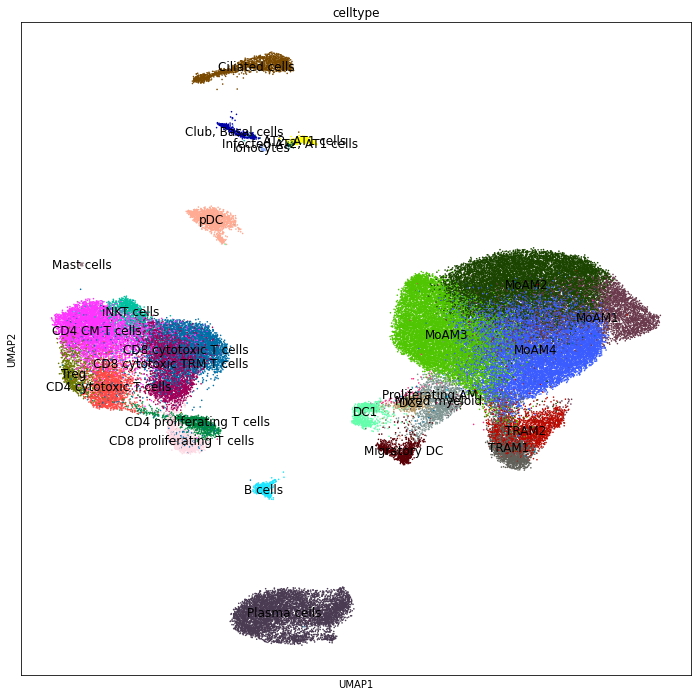

In [40]:
sc.pl.umap(
    covid, 
    color="celltype", 
    size=10, 
    legend_loc="on data",
#     legend_fontoutline=3,
    legend_fontweight="normal",
    legend_fontsize=12
)

In [48]:
covid.obs = rc2.obs.loc[covid.obs_names, :]

In [51]:
covid.write_h5ad("../data/04dataset/04obj-covid.h5ad")

In [54]:
sc.tl.rank_genes_groups(covid, "celltype", method="wilcoxon", n_genes=200)
covid_markers = sc_utils.get_markers(covid, "celltype")

In [55]:
covid_markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False]).to_csv("04covid-markers.csv")

In [33]:
covid.obs.to_csv("04covid-metadata.csv")

## DEGs between TRAM1 and TRAM2

In [7]:
trams = covid[covid.obs.celltype.isin(["TRAM1", "TRAM2"]), :].copy()

In [8]:
sc.tl.rank_genes_groups(trams, "celltype", method="wilcoxon", n_genes=0)
tram_degs = sc_utils.get_markers(trams, "celltype")

/home/nmx5063/.local/share/virtualenvs/code-sz7XzLNG/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
tram_degs.sort_values(["cluster", "avg_logFC"], ascending=[True, False]).to_csv("04tram-degs.csv")